# Classificação e aspectos experimentais (Parte II)

Fontes da aula de hoje:
1. Capítulos 22 do *Livro Data Mining and Machine Learning: Fundamental Concepts and Algorithms* (https://dataminingbook.info/book_html/)

3. Várias páginas da documentação da ``scikit-learn``

3. Aula do Professor Mark Crovella (https://github.com/mcrovella/CS506-Computational-Tools-for-Data-Science/blob/master/15-Classification-II-kNN.ipynb).


# Introdução

## Nosso problema de interesse

Dados $D = \{(\mathbf{x}_i, y_i)\}_{i=1}^n$, a tarefa de classificação consiste em encontrar um modelo $f$ que aprenda dos vetores de características os rótulos.

Há dois requisitos principais:

1. Se $(\mathbf{x}, y) \in D$, então $f(\mathbf{x}) = y$ com alta probabilidade.

2. A função aprendida deve ser **generalizável**. Se um novo $\mathbf{x}$ não pertencente ao conjunto $D$ for observado, deseja-se também que $f(\mathbf{x})$ seja o rótulo correto de $\mathbf{x}$ com alta probabilidade.

## Principais desafios experimentais

1. Como avaliar um classificador?
2. Como escolher bons hiperparâmetros e evitar *overfitting*? **[Aula de hoje]**

# Questões de hoje

**Entrada:**
  - Um conjunto de dados $D = \{(\mathbf{x}_i, y_i)\}_{i=1}^n$
  - Um algoritmo de aprendizado $\mathcal{A}$ que depende de hiperparâmetros $\{\theta_1, \dots, \theta_r\}$

**Saída**
- Um modelo de predição bem treinado
  - Que tenha sido treinado com hiperâmetros adequados
  - Que não sofra de *overfitting*

# Visualizando algumas situações interessantes...

## Exemplo I - Regressão (já visto em aulas passadas)

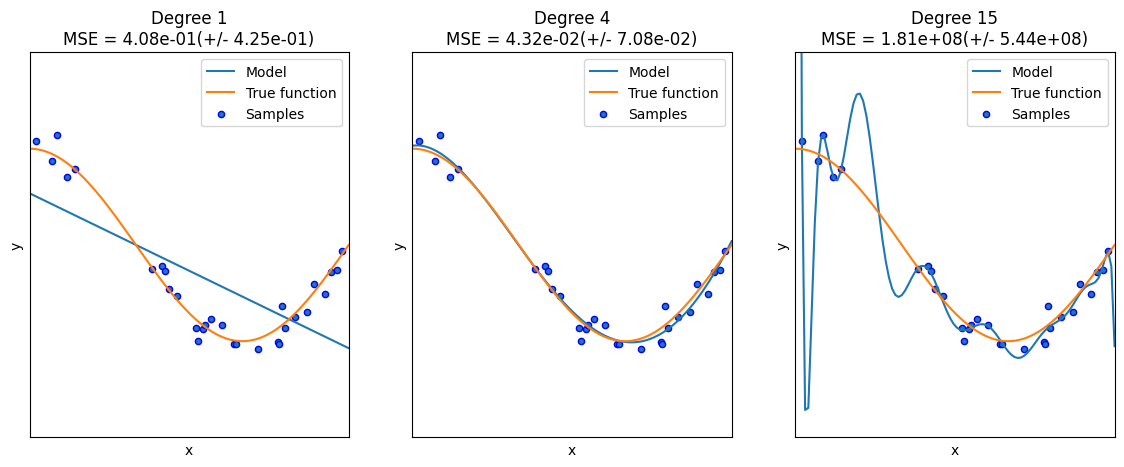

In [ ]:
#@title
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()

## Exemplo II - KNN

Nesse exemplo, vamos inspecionar como as regiões de decisão do KNN mudam quando mudamos o valor de $k$.

Para isso, considere o exemplo de problema de classificação abaixo.

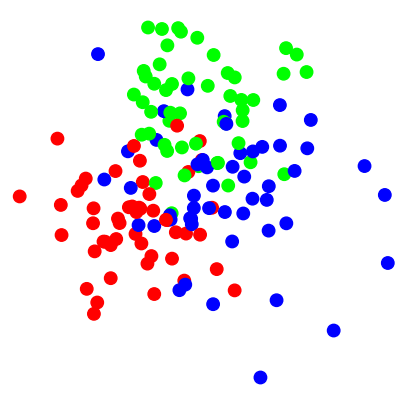

In [ ]:
#@title
import sklearn.datasets as sk_data
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

X, y = sk_data.make_blobs(n_samples=150,
                          centers=[[-2, 0],[1, 5], [2.5, 1.5]],
                          cluster_std = [2, 2, 3],
                          n_features=2,
                          center_box=(-10.0, 10.0),random_state=0)
plt.figure(figsize = (5,5))
plt.axis('equal')
plt.axis('off')
plt.scatter(X[:,0], X[:,1], c = y, cmap = cmap_bold, s = 80);

Vamos aplicar o KNN para alguns valores distintos de $k$. O resultado é apresentado abaixo.

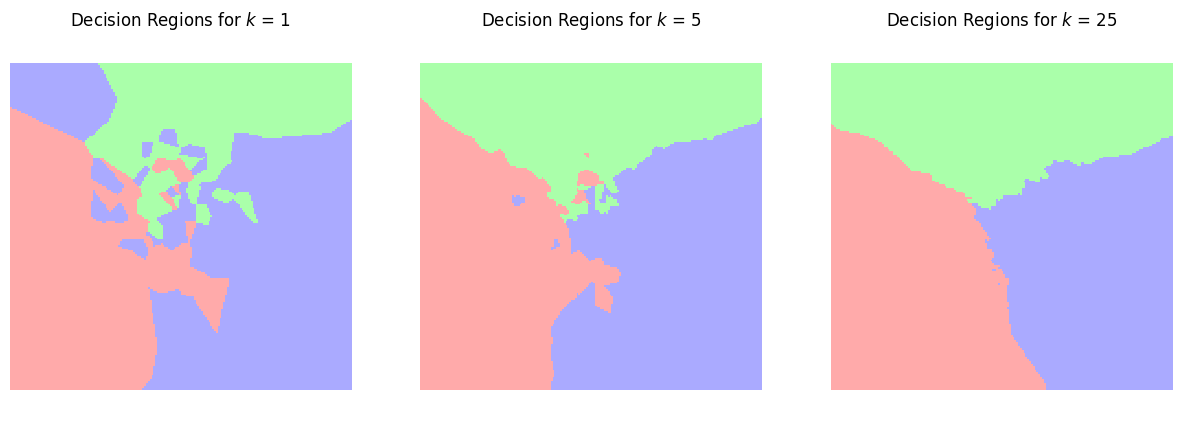

In [ ]:
#@title
from sklearn.neighbors import KNeighborsClassifier

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
h = .1  # step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))

f, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, k in enumerate([1, 5, 25]):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X, y)
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axs[i].pcolormesh(xx, yy, Z, cmap = cmap_light, shading = 'auto')
    axs[i].axis('equal')
    axs[i].axis('off')
    axs[i].set_title(f'Decision Regions for $k$ = {k}');

## Exemplo III - KNN

O exemplo abaixo mostra que aumentar o $k$ arbitrariamente pode gerar outros problemas...

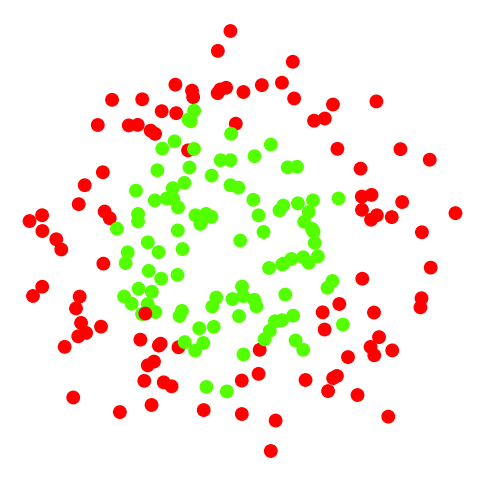

In [ ]:
#@title
import sklearn.datasets as datasets

X, y = datasets.make_circles(n_samples = 200, noise=.2, factor=.5, random_state=1)

plt.figure(figsize = (6,6))
plt.prism()  # this sets a nice color map
plt.scatter(X[:, 0], X[:, 1], c=y, s = 80)
plt.axis('off')
plt.axis('equal');

In [ ]:
k = 100 # 10 # 1, 2, 10, 20...

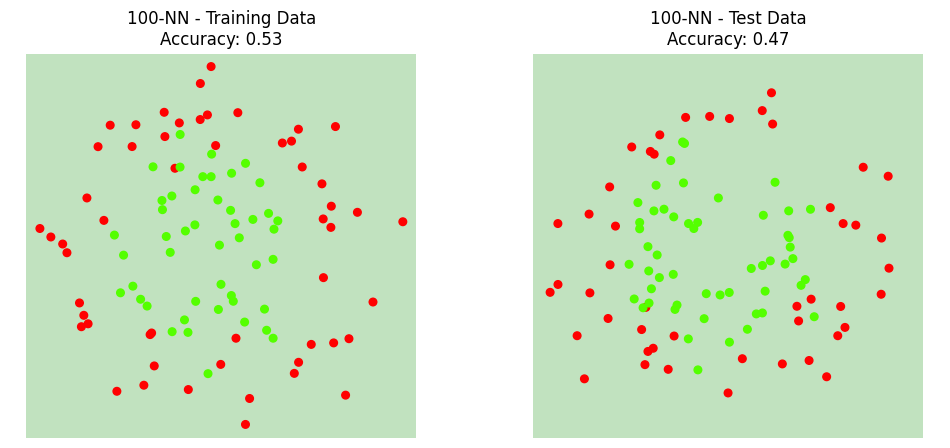

In [ ]:
#@title
import sklearn.model_selection as model_selection

fig_size = (12, 5)

x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
plot_step = 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

np.random.seed(1)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.5)


knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(X_train, y_train)
y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)

Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize = fig_size)
plt.subplot(1, 2, 1)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.3)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30)
plt.axis('equal')
plt.axis('off')
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
plt.title(f'{k}-NN - Training Data\nAccuracy: {knn.score(X_train, y_train)}');

plt.subplot(1, 2, 2)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.3)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=30)
plt.axis('equal')
plt.axis('off')
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
plt.title(f'{k}-NN - Test Data\nAccuracy: {knn.score(X_test, y_test)}');


## Exemplo IV - Árvore de Decisão

O próximo exemplo ilustra a mesma situação com relação a uma árvore de decisão.

In [ ]:
import sklearn.tree as tree
#dtc = tree.DecisionTreeClassifier(max_leaf_nodes = 3)
dtc = tree.DecisionTreeClassifier()

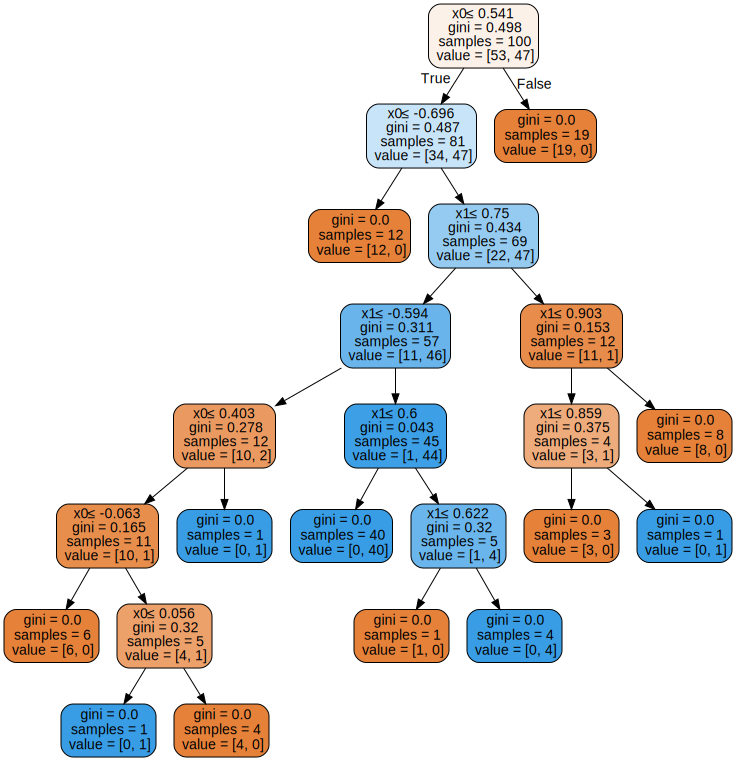

In [ ]:
#@title
import graphviz
import pydotplus

dtc.fit(X_train,y_train);

dot_data = tree.export_graphviz(dtc, out_file=None,
                     filled=True, rounded=True,
                     special_characters=True)

graph = graphviz.Source(dot_data)
graph.render("dt-vis",view = True)
graph

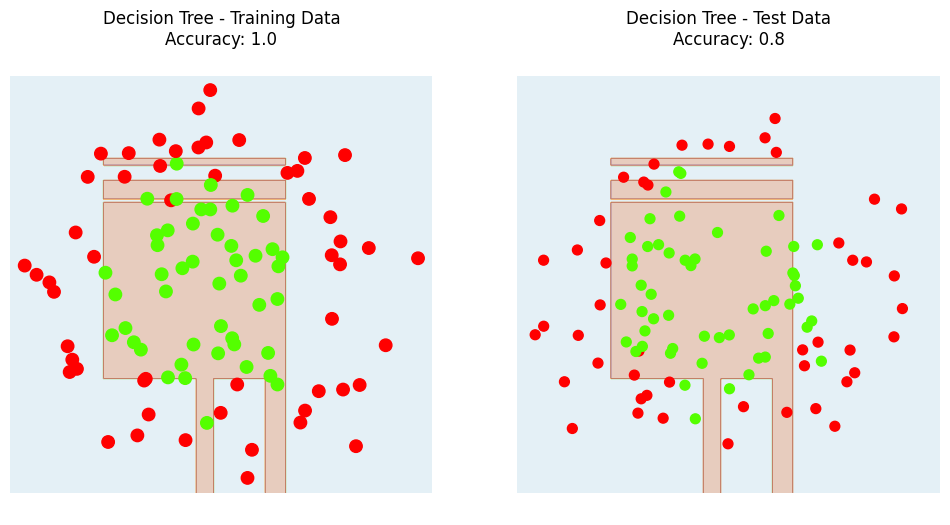

In [ ]:
#@title
Z = dtc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.3)
plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, s = 80)
plt.axis('equal')
plt.axis('off')
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
plt.title(f'Decision Tree - Training Data\nAccuracy: {dtc.score(X_train, y_train)}');

plt.subplot(1, 2, 2)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.3)
plt.scatter(X_test[:, 0], X_test[:, 1], c = y_test, s = 50)
plt.axis('equal')
plt.axis('off')
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
plt.title(f'Decision Tree - Test Data\nAccuracy: {dtc.score(X_test, y_test)}');


# Escolhendo hiperparâmetros e Evitando *overfitting*

Bom, nesse momento já deve ter ficado claro que **escolher hiperparâmetros** e evitar *overfitting* são tarefas relacionadas...

Há na literatura várias técnicas para executar essas duas tarefas de forma satisfatória. Hoje veremos uma das mais populares.

Voltando ao nosso problema original. Nossa entrada é:
  - Um conjunto de dados $D = \{(\mathbf{x}_i, y_i)\}_{i=1}^n$
  - Um algoritmo de aprendizado $\mathcal{A}$ que depende de hiperparâmetros $\{\theta_1, \dots, \theta_r\}$

## Passo 1 - Separando o conjunto de testes

Vamos reter, aleatoriamente uma porção do conjunto $D$ para testes. É comum que o conjunto de testes tenha aproximatamente 25% do conjunto de dados.

Assim, o conjunto de testes é denominado $D_{\text{test}}$ e o restando, que utilizaremos para treinamento, é denominado $D_{\text{train}}$.

**IMPORTANTE:** É extremamente importante que durante o projeto/treinamento de um classificador, **NENHUMA** informação de $D_{\text{test}}$ seja utilizada! Caso contrário, estaremos correndo risco de *overfitting*.

## Passo 2 - *$K$-Fold cross-validation*

Após reter o conjunto de teste, fazemos uma nova divisão do conjunto de treinamento em $K$ *folds*. Esses *folds* serão utilizados para fazer a escolha de **hiperparâmetros**. [fonte](https://scikit-learn.org/stable/modules/cross_validation.html)

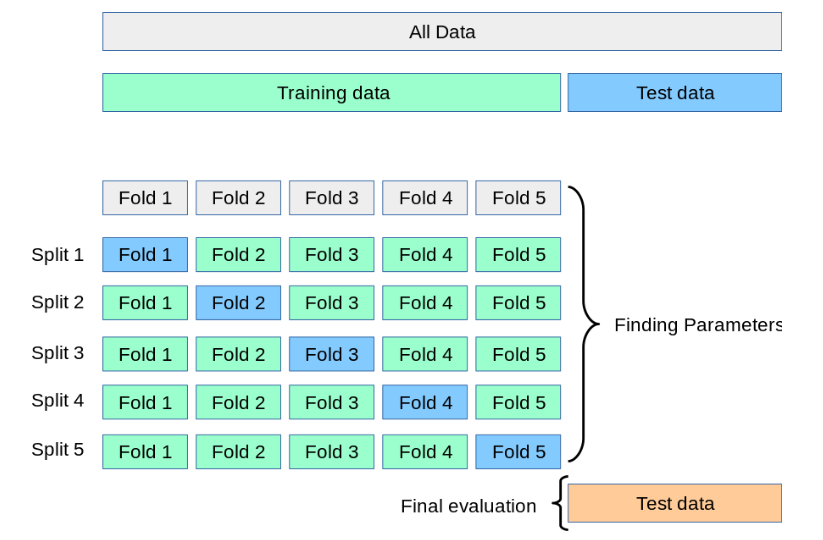

O algoritmo abaixo apresenta o processo de escolha. No algoritmo, vamos considerar que $\Theta$ é um conjunto de valores candidatos para os hiperparâmetros do algoritmo sendo usado.

1. Embaralhe o conjunto $D_{\text{train}}$
2. $D_1, \dots, D_K ←$ particione $D_{\text{train}}$ em $K$ partes iguais
3. **Para cada** $\mathbf{\theta} \in \Theta$
4. >**Para** $i ← 1$ **até** $K$
5. >>$M_{\mathbf{\theta}, i} ←$ Treine o classificador $\mathcal{A}$ em $D∖D_i$ e $\mathbf{\theta}$
6. >>$a_{\mathbf{\theta}, i}←$ Compute a acurácia do classificador treinado em $D_i$
7. > $a_{\mathbf{\theta}}←\frac{1}{K}\sum_{i = 1}^Ka_{\mathbf{\theta}, i}$
8. $\mathbf{\theta}_{\text{best}}←\arg\max_{\mathbf{\theta} \in \Theta}a_{\mathbf{\theta}}$
9. $M←$ Retreine o classificador usando $\mathcal{A}$ em $D_{\text{train}}$ e $\mathbf{\theta}_{\text{best}}$
10. **Retorne** $M$

A figura abaixo exemplifica o processo como um todo. [fonte](https://scikit-learn.org/stable/modules/cross_validation.html)

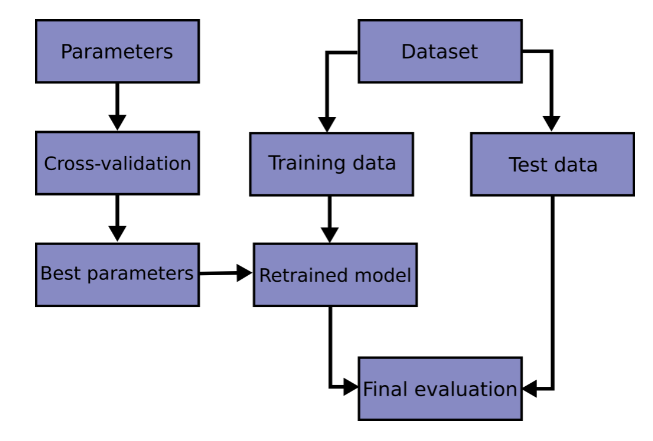

Além de *$K$-Fold Cross-Validation*, há uma grande variedade de técnicas (relacionadas e similares) para escolher hiperparâmetros e evitar *overfitting*. Um tutorial com vários exemplos é apresentado na documentação da ``scikit-learn``.

# Um exemplo prático

In [ ]:
from sklearn.datasets import load_breast_cancer

In [ ]:
X, y = load_breast_cancer(return_X_y = True, as_frame = True)
X

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


Passo 1, separando conjuntos de treino e teste

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Conjunto de hiperparâmetros candidatos

In [ ]:
params = {'n_neighbors': np.arange(1, 31)}
params

{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])}

Observe que as colunas da matriz de dados têm ordens de grandeza diferentes. É uma boa prática, pré-processar os dados para evitar esse problema.

Devemos criar um ``scaler`` utilizando o conjunto de dados

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)

A classe ``GridSearchCV`` executa o algoritmo discutido anteriormente e nos retorna o melhor modelo. Por padrão, é utilizado um *5-fold Cross-Validation*.

In [ ]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(KNeighborsClassifier(), params, n_jobs = -1)
clf.fit(X_train, y_train);

Agora, vamos aplicar a mesma transformação no conjunto de teste e vamos avaliar o modelo neste conjunto.

In [ ]:
X_test =  scaler.transform(X_test)
y_predicted = clf.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        54
           1       0.98      0.98      0.98        89

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143



## Observações

1. A biblioteca ``scikit-learn`` possui uma classe chamada ``Pipeline`` que permite agrupar todos os passos em um único pipeline/fluxo. Veja [aqui](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).
3. Nas próximas aulas, vamos incorporar os métodos discutidos acima nos novos algoritmos estudados. Isso vai ser interessante, principalmente, quando estudarmos SVM.
3. Em algumas situações, principalmente quando escrevendo artigos científicos, é comum repetir todo o processo acima algumas vezes. Assím, é possível apresentar o desempenho do classificador através de uma média e uma variância (o que permite calcular intervalos de confiança -- mais detalhes no livro texto). Isso é essencial para podermos comparar o desempenho de vários classificadores.
4. [Optuna](https://optuna.readthedocs.io/en/stable/index.html) é uma biblioteca popular só para realizar escolha de hiperparâmetros.
5. O que discutimos vale para um conjunto de dados sem correlação temporal. Validação cruzada para dados temporais exige mais cuidado (não pode treinar no futuro e testar no passado).

# What is next?

Nas próximas aulas, discutiremos alguns classificadores mais sofisticados.